In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

C:\Users\ranam\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = 224  
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
num_classes = len(class_names)

Found 5505 files belonging to 6 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [5]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

58889256/58889256 [==============================] - 37s 1us/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 6424326 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
138/138 [==============================] - 459s 3s/step - loss: 4.0214 - accuracy: 0.8287 - val_loss: 0.1684 - val_accuracy: 0.9540
Epoch 2/10
138/138 [==============================] - 491s 4s/step - loss: 0.3927 - accuracy: 0.9058 - val_loss: 0.1633 - val_accuracy: 0.9614
Epoch 3/10
138/138 [==============================] - 441s 3s/step - loss: 0.3116 - accuracy: 0.9165 - val_loss: 0.1162 - val_accuracy: 0.9577
Epoch 4/10
138/138 [==============================] - 446s 3s/step - loss: 0.2462 - accuracy: 0.9348 - val_loss: 0.1060 - val_accuracy: 0.9688
Epoch 5/10
138/138 [==============================] - 485s 4s/step - loss: 0.2127 - accuracy: 0.9446 - val_loss: 0.0752 - val_accuracy: 0.9761
Epoch 6/10
138/138 [==============================] - 476s 3s/step - loss: 0.2005 - accuracy: 0.9523 - val_loss: 0.0345 - val_accuracy: 0.9835
Epoch 7/10
138/138 [==============================] - 508s 4s/step - loss: 0.2783 - accuracy: 0.9345 - val_loss: 0.1026 - val_accuracy: 0.9816

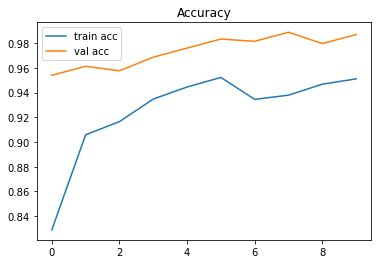

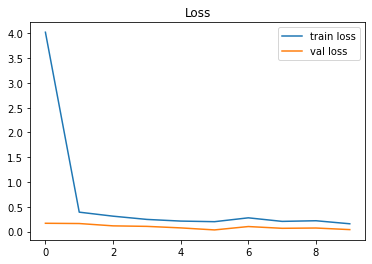

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

18/18 [==============================] - 49s 3s/step - loss: 0.0194 - accuracy: 0.9931
Test Loss: 0.019379492849111557
Test Accuracy: 0.9930555820465088


1/1 [==============================] - 3s 3s/step


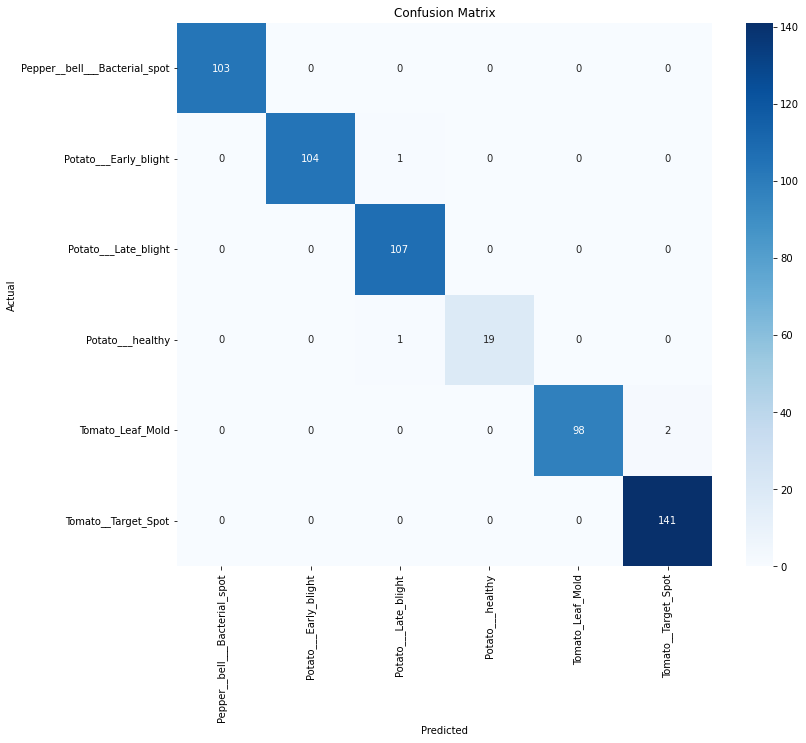

                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       1.00      1.00      1.00       103
        Potato___Early_blight       1.00      0.99      1.00       105
         Potato___Late_blight       0.98      1.00      0.99       107
             Potato___healthy       1.00      0.95      0.97        20
             Tomato_Leaf_Mold       1.00      0.98      0.99       100
          Tomato__Target_Spot       0.99      1.00      0.99       141

                     accuracy                           0.99       576
                    macro avg       0.99      0.99      0.99       576
                 weighted avg       0.99      0.99      0.99       576

Macro F1 Score: 0.9905286270803937
Weighted F1 Score: 0.9930399091065301


In [13]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

print("Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1 Score:", f1_score(y_true, y_pred, average='weighted'))